In [1]:
#載入套件
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import pandas as pd

In [15]:
# 讀取數據
labels_df = pd.read_csv('../final-2.csv')

# 讀取欲訓練RESNET50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 全局平均持畫
x = GlobalAveragePooling2D()(base_model.output)

# 模型建立
model = Model(inputs=base_model.input, outputs=x)

# 數據生成
image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 圖像設定
image_generator = image_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='../JPG-224-2/',
    x_col='pic_id',
    y_col='span',
    target_size=(224, 224),
    batch_size=16,  
    class_mode=None,
    shuffle=True
)

# 記憶體不足，分批提取特徵
def extract_features(image_generator, model, num_samples):
    batch_size = image_generator.batch_size
    features = np.zeros((num_samples, 2048))
    i = 0

    for inputs_batch in image_generator:
        features_batch = model.predict(inputs_batch)
        end_index = min((i + 1) * batch_size, num_samples)
        features[i * batch_size : end_index] = features_batch[:end_index - i * batch_size]
        i += 1
        if i * batch_size >= num_samples:
            break

    return features

# 所有數據及特徵
cnn_features = extract_features(image_generator, model, len(labels_df))

Found 661626 validated image filenames.


In [16]:
# 設定X
X = cnn_features

# 設定y
y = labels_df['span'].astype('category').cat.codes

# 分割訓練與測試
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)


In [17]:
%%time
from xgboost import XGBClassifier
# 超參數設置範例
parameters = {
    'max_depth': [7],
    'n_estimators': [150],
    'learning_rate': [0.1],
    
}

#訓練模型，使用 GPU
xgb_model = XGBClassifier(tree_method='hist', device='cuda')
clf = GridSearchCV(xgb_model, parameters, cv=3, n_jobs=1, scoring='accuracy', verbose=2)
clf.fit(X_train, y_train)

# 最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=150; total time=39.8min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=150; total time=37.1min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=150; total time=35.1min
最佳參數： {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
最佳分數： 0.29005667852357486
CPU times: total: 1h 21min 56s
Wall time: 2h 37min 43s


In [8]:
%%time
# 超參數設置
parameters = {
    'max_depth': [5, 7],
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    
}

#訓練模型，使用 GPU
xgb_model = xgb.XGBClassifier(n_jobs=1, tree_method='gpu_hist')
clf = GridSearchCV(xgb_model, parameters, cv=3, n_jobs=1, scoring='accuracy', verbose=2)
clf.fit(X_train, y_train)

# 最佳參數和最佳分數
print("最佳參數：", clf.best_params_)
print("最佳分數：", clf.best_score_)


最佳參數： {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
最佳分數： 0.3509292428597009
CPU times: user 1d 1h 34min, sys: 16.6 s, total: 1d 1h 34min 16s
Wall time: 1d 1h 33min 25s


Accuracy: 0.2912730680289588
Precision: 0.20211712873478282
Recall: 0.2912730680289588
F1 Score: 0.13436303711289765


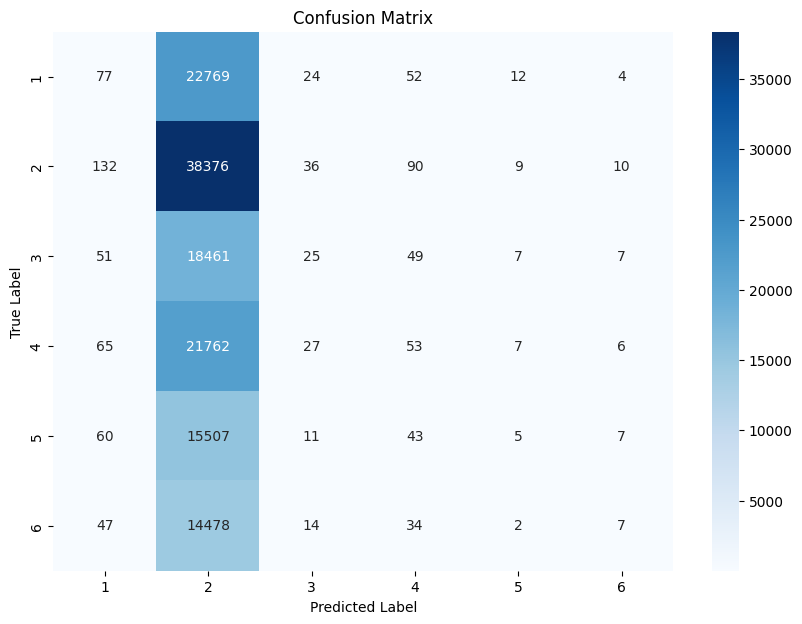

In [18]:
#分類評估
# 使用最佳模型预测
y_pred = clf.best_estimator_.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# 混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
class_names = [1, 2, 3, 4, 5, 6]  
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()